# Imports

In [2]:
import random
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd    
import time
from mlxtend.evaluate import permutation_test

import joypy
from matplotlib import cm

from get_new_sexism_probs import get_new_sexism_probs
import run_meetings as run_meetings
import institution as environment
import workerAgentObjects as Agent
import meeting as meeting

import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import pingouin as pg # stats
import pickle


# Exploring the Classes


# Agent

The Agent class represents an agent with a baseline level of sexism, 
who can converse with another Agent, 
can object to sexism directed own gender (e.g. 40% of times) or other gender (e.g. 20% of times),
incur or receive costs,
update its sexism probability.


In [2]:
sex_prob=.2
bob = Agent.workerAgent('Male',sex_prob ,obj_prob=.66, ally_prob=.33)
bob.describe()

'#(): agent, Male : allyp = 0.33, sexism = 0.2.'

# Institution

Samples 100 agents with a given gender ratio, e.g. .2 or .5 female.
Sets up with agents with different probabilities of sexism or racism.

In [3]:
gender_ratio=.2
inst = environment.environment(gender_ratio)
inst.describe()

Environment with 100 agents loaded.
Indices for female agents:
[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Indices for male agents:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]


# Meeting

The class "meeting"s" implements the class "instituion". There,
parameters from empirical studies, in colab with Mina Cikara @Harvard. 

Every meeting happens among 2-8 agents sampled randomly from the total 
agents in the institution.

The main parameters are:


1) Self objection (probability of objecting if there's sexism towards own group)

2) Objection for other gender (probability of being an ally)

3) The cost of objection for own gender is: 1, 
    cost of ally objection, i.e. objection for sexism against other gender: .9
    (based on empirical results)

4) Change in behavior (sexism probabilities):

    increase in sexism: if a sexist comment happens in a meeting and no one objects,
    everyone from the perpetrator's gender increases their probabilty of sexism
    by 10% of the original probability (based on empirical studies)

    decrease in sexism: 10% or 5% of initial sexism decrease 
    if someone from same, or other, gender objects to sexism in the meeting.
    (based on empirical studies)

In [15]:
meet1= meeting.meeting(inst)

# Simulation

Gender ratio: between 0 and 1

Sexism distribution: Initialized equally for male and female
	50% never, 10% p=.2, 10% p=.4, 10% p=.6, 10% p=.8, 10% p=1

Inferred from empirical findings, need more data to optimize:

Prob objection: 40% object for own gender with prob (.33, .33, .66, 1)
      20% object for other gender with prob (.33, .66)
      
Increase in sexism: 10% after sexism + no objection

Decrease in sexism: 10% if own gender confronts, 5% if other gender





In [6]:
######### KEY PARAMETERS #############
allmeets = [1000] #[1000,2000,3000,4000]    # number of meetings (each with 2-8 out of 100 agents)
gender_ratio=.2      # gender ratio 
nsim = 1000           # number of simulations
######### /KEY PARAMETERS #############

allratios=[.1,.2,.3,.4,.5]

use_the_past = 33
    # use the past ==1: same params, 11: 10% more allies who object always
    # 1111: more men, 2: double women's objections
    # 22: all women object all the time
    # 3: women same as before, allies object all the time
    # 33: adding 1 and 1 to each group
    # reduce objection costs
    # 4:: no objection equality
    # 5:: no objection normal


for n_meetings in tqdm(allmeets):

#for gender_ratio in tqdm(allratios):    
    anti_f_sexism , anti_m_sexism=[],[]
    sexf_bef, sexm_bef=[], []
    sexf_aft, sexm_aft=[], []
    costsf, costsm=[],[]
    costfmeet, costmmeet = [],[]

    ######### 50/50 using past params?? #############

    old_gender_ratio = .2
    if use_the_past>0 and use_the_past<5:
        pickle_file=f'env{old_gender_ratio}_sex_prob_args.pkl'            
        with open(pickle_file, 'rb') as input:
            pickled_args = pickle.load(input)
            
    #################################################

    #for n_meetings in [500,1000, 1500, 2000, 2500, 3000, 3500]:    

    for simulation in tqdm(range (nsim)):   
        # 1 run the simulations using the fast, or fresh 
        if use_the_past>0 and use_the_past<5:
            env=run_meetings.run_meetings(gender_ratio, n_meetings,pickled_args[0],pickled_args[1]) 
        else:
            env=run_meetings.run_meetings(gender_ratio, n_meetings)    
            
        # 2 SAVE sexism results  FOR SWARMPLOT
        # parametesr below about anti_f/anti_m count of sexism, not costs
        anti_f_sexism.append(env.anti_f_sexism/env.mixedgendermeetings) 
        anti_m_sexism.append(env.anti_m_sexism/env.mixedgendermeetings) 
        #anti_f_sexism.append(env.anti_f_sexism)     #anti_m_sexism.append(env.anti_m_sexism)    #total_sexism[simulation]=env.total_sexism
        
        # 5 sexism distribution before and after convos    
        env.getsexprob()
    
        sexf_bef.extend(env.sexf_bef)
        sexm_bef.extend(env.sexm_bef)
        sexf_aft.extend(env.sexp_f)
        sexm_aft.extend(env.sexp_m)
        
        # 7 GET COSTS for f & m
    
        costsf.extend(env.total_cost_f)
        costfmeet.extend( [x / env.mixedgendermeetings for x in env.total_cost_f])
        costsm.extend(env.total_cost_m)
        costmmeet.extend( [x / env.mixedgendermeetings for x in env.total_cost_m])

    pickle_stats=0
    if pickle_stats:
    # let's pickle everything for this number of convos
    # if there's the pure prefix it means that it was not divided by the number of mixed meetings
    #with open(f'ratio{gender_ratio}_{use_the_past}_{n_meetings}meets_{nsim}nsim.pkl', 'wb') as outputfile:  # Python 3: open(..., 'wb')
    #with open(f'cost8_ratio{gender_ratio}_{use_the_past}_{n_meetings}meets_{nsim}nsim.pkl', 'wb') as outputfile:  # Python 3: open(..., 'wb')    
        with open(f'prcost8_inc_ratio{gender_ratio}_{use_the_past}_{n_meetings}meets_{nsim}nsim.pkl', 'wb') as outputfile:  # Python 3: open(..., 'wb')    
            pickle.dump([anti_f_sexism, anti_m_sexism, 
                     sexf_bef,sexm_bef, 
                     sexf_aft,sexm_aft,
                     costsf,costsm, nsim, 
                     costfmeet, costmmeet], outputfile, pickle.HIGHEST_PROTOCOL )

    pg.ttest(anti_f_sexism, anti_m_sexism)
    print("Done. Gender ratio: %s" % env.gender_ratio)
    env.mixedgendermeetings

Done. Gender ratio: 0.2


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pingouin/bayesian.py:114: RuntimeWarning: divide by zero encountered in double_scalars
  return np.round(1 / bf01, 3)


In [17]:
# for joy plots: making a big panda

#### HERE YOU DETERMINE WHICH TO PICK FROM ############
CONDITION=0 #4
prefix='prcost8_inc' #'rcost8_inc' #'cost8' --> ally cost is .8 not .9
#######################################################

antidata=[]
costdata=[]
costmf = []
sexistp=[]
######### KEY PARAMETERS #############
n_meetings = 1000     # number of meetings (each with 2-8 out of 100 agents)
nsim = 1000           # number of simulations
######### /KEY PARAMETERS #############
ratios=[.1,.2,.3,.4,.5]
for gender_ratio in ratios:
    print(gender_ratio)
    anti_f_sexism,anti_m_sexism=[],[]
    costsf, costsm=[],[]
    sexfbef, sexmbef, sexfaft, sexmaft = [],[],[],[]
    # 1
    #with open(f'ratio{gender_ratio}_{n_meetings}meets_{nsim}nsim.pkl', 'rb') as input:
    # 2  [            anti_f_sexism, anti_m_sexism, 
    #                 sexf_bef, sexm_bef, 
    #                 sexf_aft,sexm_aft,
    #                 costsf,costsm, nsim, 
    #                 costfmeet, costmmeet]
    with open(f'{prefix}_ratio{gender_ratio}_{CONDITION}_{n_meetings}meets_{nsim}nsim.pkl', 'rb') as input:
        pickled_args = pickle.load(input)
        anti_f_sexism,anti_m_sexism=pickled_args[0],pickled_args[1]
        # let's get male and female costs
        costsf = pickled_args[-2]
        costsm = pickled_args[-1]
        # sexism probabilities
        sexfbef, sexmbef = pickled_args[2],pickled_args[3]
        sexfaft, sexmaft = pickled_args[4],pickled_args[5]
        for i in range(len(anti_f_sexism)):
            # count sexism and costs for male and female
            antidata.append([gender_ratio, anti_f_sexism[i], anti_m_sexism[i]])
            costmf.append([gender_ratio, costsf[i], costsm[i]])
            # overall instution costs            
            costdata.append([gender_ratio, costsf[i]+ costsm[i]])
            # sexismprob
            sexistp.append(([gender_ratio, 'female',  'before', sexfbef[i]]))
            sexistp.append(([gender_ratio, 'female',  'after' , sexfaft[i]]))
            sexistp.append(([gender_ratio, 'male',    'before', sexmbef[i]]))
            sexistp.append(([gender_ratio, 'male',    'after', sexmaft[i]]))
            # making dataframes for joyplots     
        
joydf = pd.DataFrame(antidata, columns=['ratio', 'anti_f', 'anti_m'])
costmf_df = pd.DataFrame(costmf, columns=['ratio', 'costsf', 'costsm'])
costdf= pd.DataFrame(costdata, columns=['ratio',  'cost_inst'])
sexpdf = pd.DataFrame(sexistp, columns=['ratio','gender', 'when', 'sex_prob'])                                                   

0.1
0.2
0.3
0.4
0.5


<Figure size 900x900 with 0 Axes>

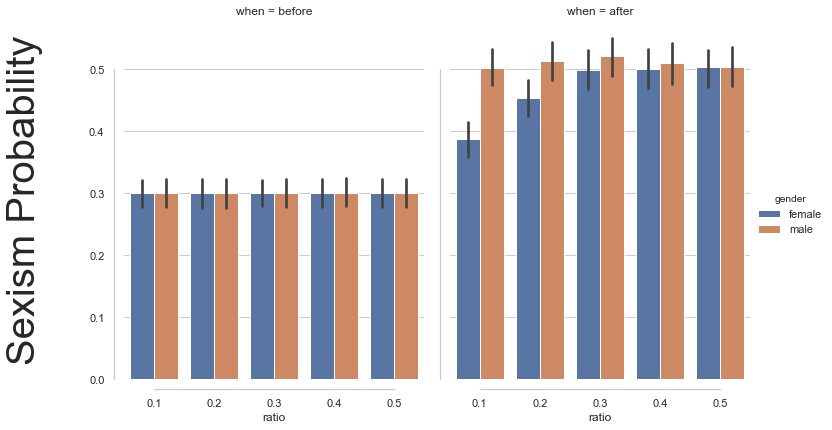

In [6]:
# COND 5
plt.figure(figsize=(3,3), dpi= 300)
sns.set(style="whitegrid")

g = sns.catplot(x="ratio", y="sex_prob",
                hue="gender", col="when",
                 data=sexpdf, kind="bar",
                 height=6, aspect=.8)

g.fontsize=40
#g.set_xlabels("Before    After", fontsize=30)
g.set_ylabels("Sexism Probability\n", fontsize=40)
n_meetings=1000

sns.despine(offset=10, trim=True)

<Figure size 900x900 with 0 Axes>

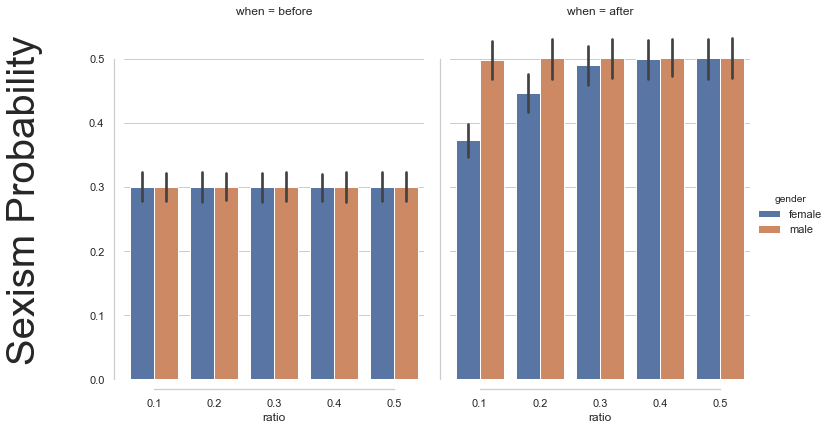

In [4]:
# CONDITION = 4
#    with open(f'cost8_ratio{gender_ratio}_{CONDITION}_{n_meetings}meets_{nsim}nsim.pkl', 'rb') as input:


plt.figure(figsize=(3,3), dpi= 300)
sns.set(style="whitegrid")

g = sns.catplot(x="ratio", y="sex_prob",
                hue="gender", col="when",
                 data=sexpdf, kind="bar",
                 height=6, aspect=.8)

g.fontsize=40
#g.set_xlabels("Before    After", fontsize=30)
g.set_ylabels("Sexism Probability\n", fontsize=40)
n_meetings=1000

sns.despine(offset=10, trim=True)


<Figure size 3000x2400 with 0 Axes>

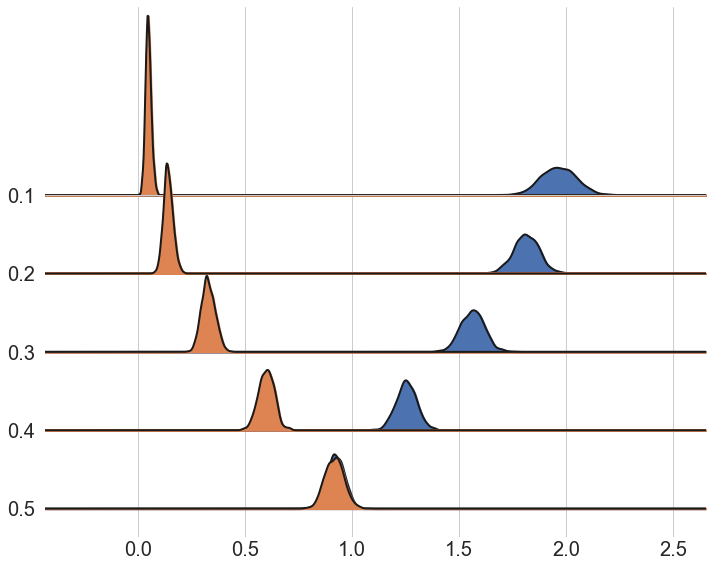

In [4]:
plt.figure(figsize=(10,8), dpi= 300)

fig, ax = joypy.joyplot(joydf, column=['anti_f', 'anti_m'], grid=True,
                        linewidth=2,fade=False,overlap=2.8,
                        by="ratio", #x_range=[.6,1.6],
                        ylim='max', figsize=(10,8),kind="kde",
                        xlabelsize=20, ylabelsize=20)

# EQUALITY POLICY

Here we plot the results of equality policy after 1000, 2000, 3000, and 4000 meetings only for meetings after .2 female raito. We choose .2 because it is approximates common ratio in tech, politics, congress, etc.

In [4]:
prefix='prcost8_inc' #'rcost8_inc' #'cost8' --> ally cost is .8 not .9



# FOR EQUALITY POLICY JOYPLOTS
eqantidata=[]
eqcostdata=[]
eqcostmf = []
eqsexistp=[]

nsim,gender_ratio = 1000 ,.5          # number of simulations
n_meets = [1000, 2000,3000,4000, 5000] #ratios=[.1,.2,.3,.4,.5]

for n_meetings in n_meets: #gender_ratio in ratios:
    print(n_meetings)
    eqanti_f_sexism,eqanti_m_sexism=[],[]
    eqcostsf, eqcostsm=[],[]
    eqsexfbef, eqsexmbef, eqsexfaft, eqsexmaft = [],[],[],[]

    with open(f'{prefix}_ratio{gender_ratio}_1_{n_meetings}meets_{nsim}nsim.pkl', 'rb') as input:
        pickled_args = pickle.load(input)
        eqanti_f_sexism,eqanti_m_sexism=pickled_args[0],pickled_args[1]
        eqcostsf = pickled_args[-2]
        eqcostsm = pickled_args[-1]
        # sexism probabilities
        eqsexfbef, eqsexmbef = pickled_args[2],pickled_args[3]
        eqsexfaft, eqsexmaft = pickled_args[4],pickled_args[5]
        for i in range(len(eqanti_f_sexism)):
            # count sexism and costs for male and female
            eqantidata.append([n_meetings, eqanti_f_sexism[i], eqanti_m_sexism[i]])
            eqcostmf.append(  [n_meetings, eqcostsf[i], eqcostsm[i]])
            # overall instution costs            
            eqcostdata.append([n_meetings, eqcostsf[i]+ eqcostsm[i]])
            # sexismprob
            eqsexistp.append(([n_meetings, 'female',  'before', eqsexfbef[i]]))
            eqsexistp.append(([n_meetings, 'female',  'after' , eqsexfaft[i]]))
            eqsexistp.append(([n_meetings, 'male',    'before', eqsexmbef[i]]))
            eqsexistp.append(([n_meetings, 'male',    'after',  eqsexmaft[i]]))
        
eqjoydf     = pd.DataFrame(eqantidata, columns=['n_meetings', 'anti_f', 'anti_m'])
eqcostmf_df = pd.DataFrame(eqcostmf,   columns=['n_meetings', 'costsf', 'costsm'])
eqcostdf    = pd.DataFrame(eqcostdata, columns=['n_meetings',  'cost_inst'])
eqsexpdf    = pd.DataFrame(eqsexistp,  columns=['n_meetings','gender', 'when', 'sex_prob'])                           

#### FIGURE ####

1000
2000
3000
4000
5000


<Figure size 3000x2400 with 0 Axes>

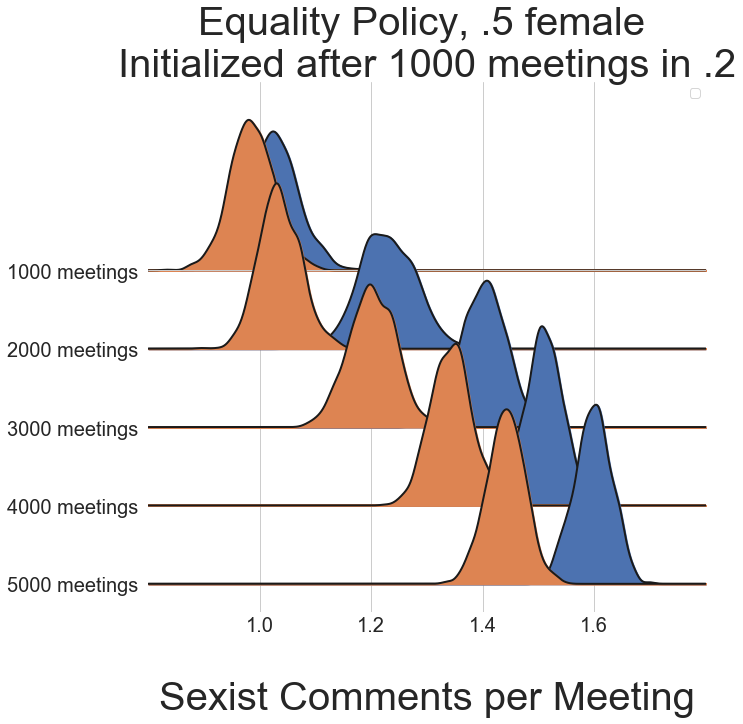

In [5]:
plt.figure(figsize=(10,8), dpi= 300)

fig, ax = joypy.joyplot(eqjoydf, column=['anti_f', 'anti_m'], grid=True,
                        linewidth=2,fade=False,overlap=2.8,
                        by="n_meetings", x_range=[.8,1.8],
                        ylim='max', figsize=(10,8),kind="kde",
                        xlabelsize=20, ylabelsize=20,
                       labels=['1000 meetings','2000 meetings','3000 meetings','4000 meetings', '5000 meetings'])

plt.title('Equality Policy, .5 female \nInitialized after 1000 meetings in .2', fontsize=40)
plt.xlabel('\nSexist Comments per Meeting', fontsize=40)
plt.legend(['Anti-female', 'Anti-male'], fontsize=12)
plt.savefig(f'eq_{prefix}_ratio{gender_ratio}_multimeets_{nsim}sim.png', bbox_inches='tight')
plt.savefig(f'eq_{prefix}_ratio{gender_ratio}_multimeets_{nsim}sim.pdf', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,8), dpi= 300)

fig, ax = joypy.joyplot(eqjoydf, column=['anti_f', 'anti_m'], grid=True,
                        linewidth=2,fade=False,overlap=2.8,
                        by="n_meetings", x_range=[.6,2],
                        ylim='max', figsize=(10,8),kind="kde",
                        xlabelsize=20, ylabelsize=20,
                       labels=['1000 meetings','2000 meetings','3000 meetings','4000 meetings'])

plt.title('Equality Policy, .5 female \nInitialized after 1000 meetings in .2', fontsize=40)
plt.xlabel('\nSexist Comments per Meeting', fontsize=40)
plt.legend(['Anti-female', 'Anti-male'], fontsize=12)
#plt.savefig(f'eq_{prefix}_ratio{gender_ratio}_multimeets_{nsim}sim.png', bbox_inches='tight')
#plt.savefig(f'eq_{prefix}_ratio{gender_ratio}_multimeets_{nsim}sim.pdf', bbox_inches='tight')

1000
1000
1000
1000


<Figure size 3000x2400 with 0 Axes>

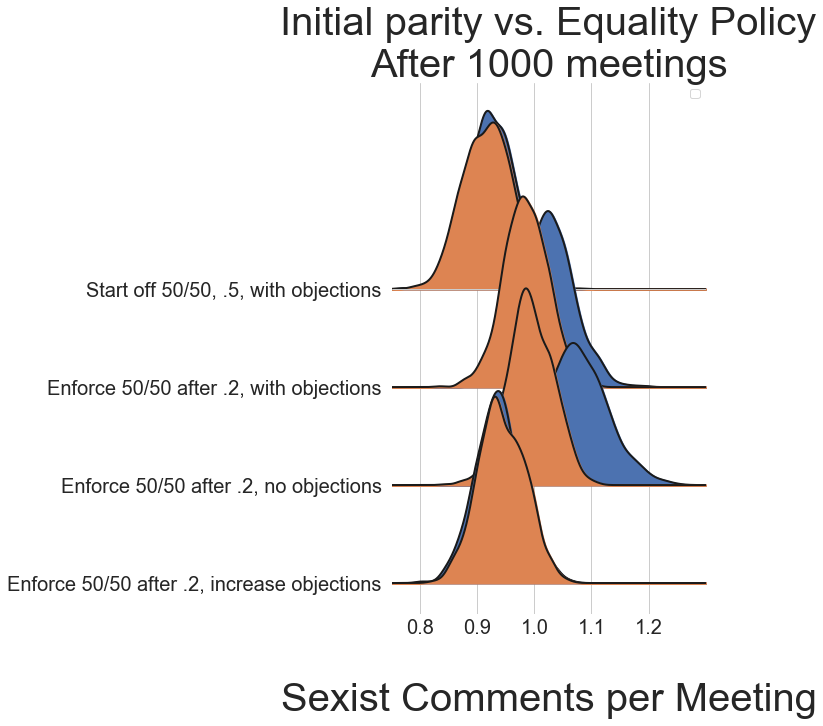

In [15]:
# FOR EQUALITY POLICY JOYPLOTS
# DOING MORE THAN JUST 50/50

eqantidata=[]
eqcostdata=[]
eqcostmf = []
eqsexistp=[]
prefix='prcost8_inc' #'cost8_inc'

nsim,gender_ratio = 1000 ,.5          # number of simulations
n_meetings=1000
for eq in [0, 1, 4, 33]: #[0, 1, 1111]: #[1,11, 111, 1111, 2, 22, 3]: #gender_ratio in ratios:
    print(n_meetings)
    eqanti_f_sexism,eqanti_m_sexism=[],[]
    eqcostsf, eqcostsm=[],[]
    eqsexfbef, eqsexmbef, eqsexfaft, eqsexmaft = [],[],[],[]

    with open(f'{prefix}_ratio{gender_ratio}_{eq}_{n_meetings}meets_{nsim}nsim.pkl', 'rb') as input:
        pickled_args = pickle.load(input)
        eqanti_f_sexism,eqanti_m_sexism=pickled_args[0],pickled_args[1]
        # let's get male and female costs
        #costsf, costsm=pickled_args[-3],pickled_args[-2]
        eqcostsf = pickled_args[-2]
        eqcostsm = pickled_args[-1]
        # sexism probabilities
        eqsexfbef, eqsexmbef = pickled_args[2],pickled_args[3]
        eqsexfaft, eqsexmaft = pickled_args[4],pickled_args[5]
        for i in range(len(eqanti_f_sexism)):
            # count sexism and costs for male and female
            eqantidata.append([eq, eqanti_f_sexism[i], eqanti_m_sexism[i]])
            eqcostmf.append(  [eq, eqcostsf[i], eqcostsm[i]])
            # overall instution costs            
            eqcostdata.append([eq, eqcostsf[i]+ eqcostsm[i]])
            # sexismprob
            eqsexistp.append(([eq, 'female',  'before', eqsexfbef[i]]))
            eqsexistp.append(([eq, 'female',  'after' , eqsexfaft[i]]))
            eqsexistp.append(([eq, 'male',    'before', eqsexmbef[i]]))
            eqsexistp.append(([eq, 'male',    'after',  eqsexmaft[i]]))
        
eqjoydf     = pd.DataFrame(eqantidata, columns=['eq', 'anti_f', 'anti_m'])
eqcostmf_df = pd.DataFrame(eqcostmf,   columns=['eq', 'costsf', 'costsm'])
eqcostdf    = pd.DataFrame(eqcostdata, columns=['eq',  'cost_inst'])
eqsexpdf    = pd.DataFrame(eqsexistp,  columns=['eq','gender', 'when', 'sex_prob'])                           

#### FIGURE ####
plt.figure(figsize=(10,8), dpi= 300)

fig, ax = joypy.joyplot(eqjoydf, column=['anti_f', 'anti_m'], grid=True,
                        linewidth=2,fade=False,overlap=2.8,
                        by="eq", x_range=[.75,1.3],
                        ylim='max', figsize=(10,8),kind="kde",
                        xlabelsize=20, ylabelsize=20, 
                        labels=['Start off 50/50, .5, with objections',
                                'Enforce 50/50 after .2, with objections',
                                'Enforce 50/50 after .2, no objections',
                                'Enforce 50/50 after .2, increase objections'])

plt.title('Initial parity vs. Equality Policy\nAfter 1000 meetings', fontsize=40)
plt.xlabel('\nSexist Comments per Meeting', fontsize=40)
plt.legend(['Anti-female', 'Anti-male'], fontsize=12)

plt.savefig(f'eq50comp_{prefix}_ratio{gender_ratio}_multimeets_{nsim}sim.png', bbox_inches='tight')
plt.savefig(f'eq50comp_{prefix}_ratio{gender_ratio}_multimeets_{nsim}sim.pdf', bbox_inches='tight')

In [12]:
# MAKING Probs For Equality Policy
# and LATER:: EQUITY POLICY
# THIS IS ALL IN THE FUNCTION :
# save_new_sexprob()

ratios=[.2,.1,.2,.3,.4,.5]
for gender_ratio in ratios:
    print(gender_ratio)
    sexfaft, sexmaft = [],[]
    # 1
    #with open(f'ratio{gender_ratio}_{n_meetings}meets_{nsim}nsim.pkl', 'rb') as input:
    # 2  [            anti_f_sexism, anti_m_sexism, 
    #                 sexf_bef, sexm_bef, 
    #                 sexf_aft,sexm_aft,
    #                 costsf,costsm, nsim, 
    #                 costfmeet, costmmeet]
    with open(f'{prefix}_ratio{gender_ratio}_0_{n_meetings}meets_{nsim}nsim.pkl', 'rb') as input:
        pickled_args = pickle.load(input)
        sexfaft, sexmaft = pickled_args[4],pickled_args[5]
        # turn into percentiles
        sexfaft.sort()
        sexmaft.sort()
        num=10
        chunkf=int(len(sexfaft)/10) 
        chunkm=int(len(sexmaft)/10)

        new_sexpf=[np.mean(sexfaft[i*(chunkf+1):i*(chunkf+1)+chunkf]) for i in range(num)]
        new_sexpm=[np.mean(sexmaft[i*(chunkm+1):i*(chunkm+1)+chunkm]) for i in range(num)]


        #print(new_sexpm, new_sexpf)
        # save and use them in the next round
        env_sex_prob_args=(new_sexpm, new_sexpf)
        ###      pickle      ###
        with open(f'env{gender_ratio}_sex_prob_args.pkl', 'wb') as output:
            pickle.dump(env_sex_prob_args, output, pickle.HIGHEST_PROTOCOL)


0.2
0.1
0.2
0.3
0.4
0.5


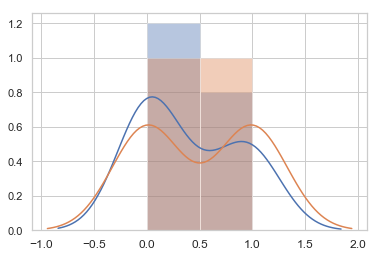

In [22]:
sns.distplot(new_sexpf)
sns.distplot(new_sexpm)

In [ ]:
sim_dataframe=joydf[ joydf['ratio']==.1 ]
sexp_a=sexpdf[sexpdf['ratio']==.1]
sexp_after=sexp_after[sexp_after['when']=='after']
fsexp_aft=sexp_after[sexp_after['gender']=='female']
msexp_aft=sexp_after[sexp_after['gender']=='male']
msexp=msexp_aft['sex_prob']



P value: 0.0000000000
ratio= 0.2, p = 0.0


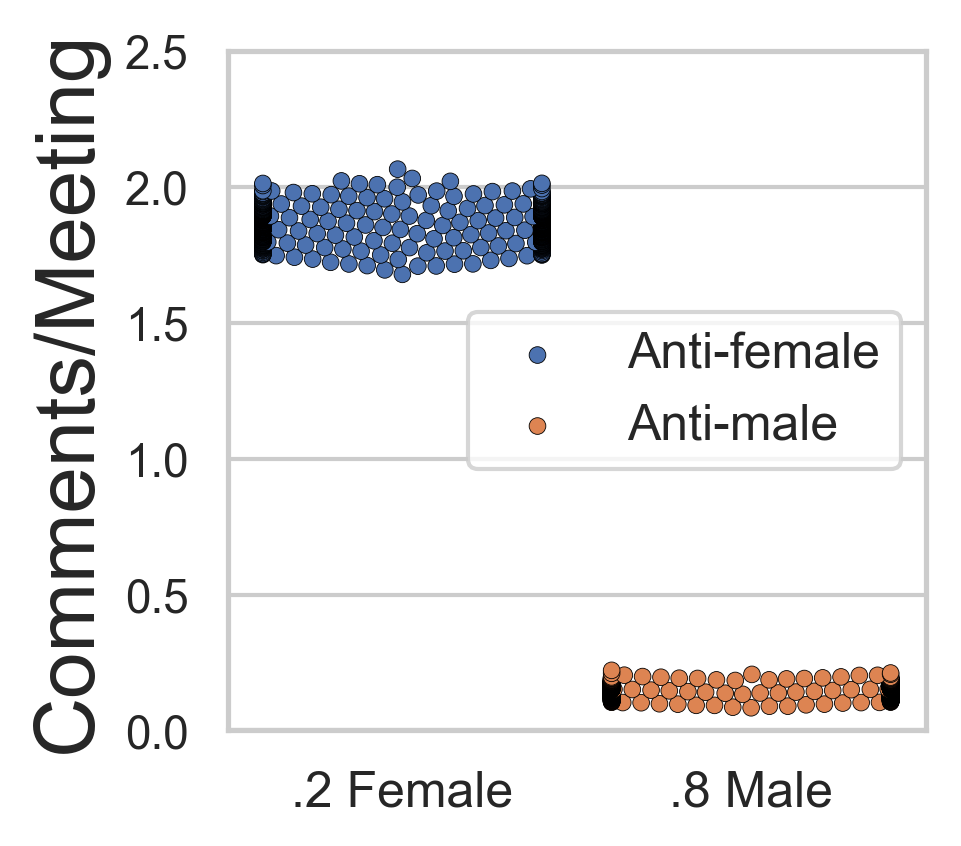

In [16]:
#  [0.  anti_f_sexism, 1 anti_m_sexism, 2 sexf_bef, 3sexm_bef,  
#  4. sexf_aft,   5 sexm_aft, 6 costsf, 7 costsm, 8 nsim], 

n_meetings,nsim=1000,1000
use_the_past=0 # making sure this is not using the equality policy
gratios=[.2]
pvals = []

for gratio in gratios:
    gender_ratio = gratio
    pickle_file=f'{prefix}_ratio{gratio}_{use_the_past}_1000meets_1000nsim.pkl'
    with open(pickle_file, 'rb') as input:        
        # for this ratio:
        pickled_args = pickle.load(input)
        
        anti_f_sexism,anti_m_sexism=pickled_args[0],pickled_args[1]
        
        p_value = permutation_test(anti_f_sexism,anti_m_sexism,
                           method='approximate',
                           num_rounds=10000,
                           seed=0)
        print('P value: %.10f' % p_value)
        P_val=round(p_value,5)
        pvals.append( P_val )
        
        print(f'ratio= {gender_ratio}, p = {P_val}')
        #plt.title(f'Comparing Sexism Against Men & Women \n Gender Ratio={gender_ratio}, {n_meetings} Meetings',fontsize=20)plt.xlabel(f'Count of Sexism/meeting, {n_meetings} Meetings',fontsize=20)
        plt.figure(figsize=(3,3), dpi= 300)

        #sns.distplot(anti_f_sexism)
        #sns.distplot(anti_m_sexism)
        sim_dataframe=pd.DataFrame({'.2 Female':anti_f_sexism, 
                            '.8 Male':anti_m_sexism})
    
        sns.swarmplot(data=sim_dataframe, size=4, edgecolor='black', linewidth=.2)
        plt.rcParams['xtick.labelsize'] = 12 
#        plt.ylabel(f'Number of Agents\n', fontsize=20)
        plt.ylabel('Comments/Meeting', fontsize=20)
        plt.legend(['Anti-female', 'Anti-male'], fontsize=12)
        #plt.xlim(0, 2.15)        
        ## SAVE *sexism* FIGS TODO: save ttests
        plt.ylim(0, 2.5)
        plt.savefig(f'swrm_ratio{gender_ratio}_meets{n_meetings}_{nsim}sim.png', bbox_inches='tight')
        plt.savefig(f'swrm_ratio{gender_ratio}_meets{n_meetings}_{nsim}sim.pdf', bbox_inches='tight')

In [18]:
prefix

'rcost8_inc'

P value: 0.6578000000
ratio= 0.5, p = 0.6578


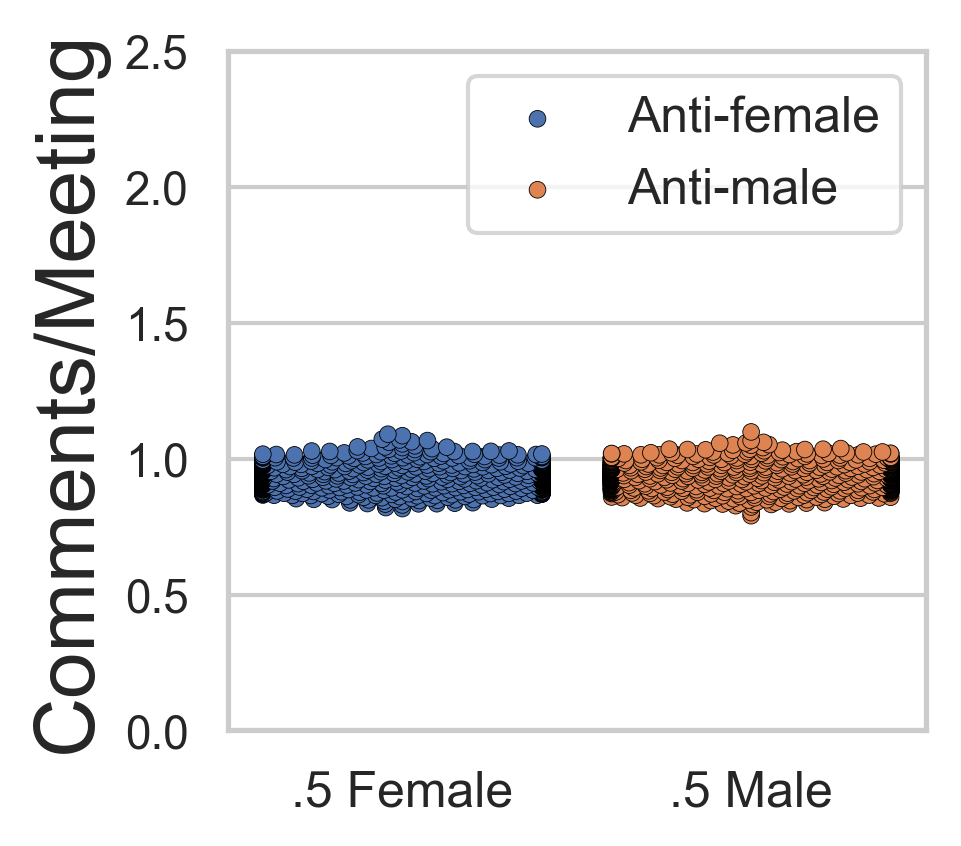

In [17]:
#  [0.  anti_f_sexism, 1 anti_m_sexism, 2 sexf_bef, 3sexm_bef,  
#  4. sexf_aft,   5 sexm_aft, 6 costsf, 7 costsm, 8 nsim], 
prefix
n_meetings,nsim=1000,1000
use_the_past=0 # making sure this is not using the equality policy
gratios=[.5]
pvals = []

for gratio in gratios:
    gender_ratio = gratio
    pickle_file=f'{prefix}_ratio{gratio}_{use_the_past}_1000meets_1000nsim.pkl'
    with open(pickle_file, 'rb') as input:        
        # for this ratio:
        pickled_args = pickle.load(input)
        
        anti_f_sexism,anti_m_sexism=pickled_args[0],pickled_args[1]
        
        p_value = permutation_test(anti_f_sexism,anti_m_sexism,
                           method='approximate',
                           num_rounds=10000,
                           seed=0)
        print('P value: %.10f' % p_value)
        P_val=round(p_value,5)
        pvals.append( P_val )
        
        print(f'ratio= {gender_ratio}, p = {P_val}')
        #plt.title(f'Comparing Sexism Against Men & Women \n Gender Ratio={gender_ratio}, {n_meetings} Meetings',fontsize=20)plt.xlabel(f'Count of Sexism/meeting, {n_meetings} Meetings',fontsize=20)
        plt.figure(figsize=(3,3), dpi= 300)

        #sns.distplot(anti_f_sexism)
        #sns.distplot(anti_m_sexism)
        sim_dataframe=pd.DataFrame({'.5 Female':anti_f_sexism, 
                            '.5 Male':anti_m_sexism})
    
        sns.swarmplot(data=sim_dataframe, size=4, edgecolor='black', linewidth=.2)
        
#        plt.ylabel(f'Number of Agents\n', fontsize=20)
        plt.ylabel('Comments/Meeting', fontsize=20)
        plt.legend(['Anti-female', 'Anti-male'], fontsize=12)
        plt.rcParams['xtick.labelsize'] = 12  

        #plt.xlim(0, 2.15)        
        ## SAVE *sexism* FIGS TODO: save ttests
        plt.ylim(0, 2.5)
        plt.savefig(f'swrm_ratio{gender_ratio}_meets{n_meetings}_{nsim}sim.png', bbox_inches='tight')
        plt.savefig(f'swrm_ratio{gender_ratio}_meets{n_meetings}_{nsim}sim.pdf', bbox_inches='tight')

<Figure size 900x900 with 0 Axes>

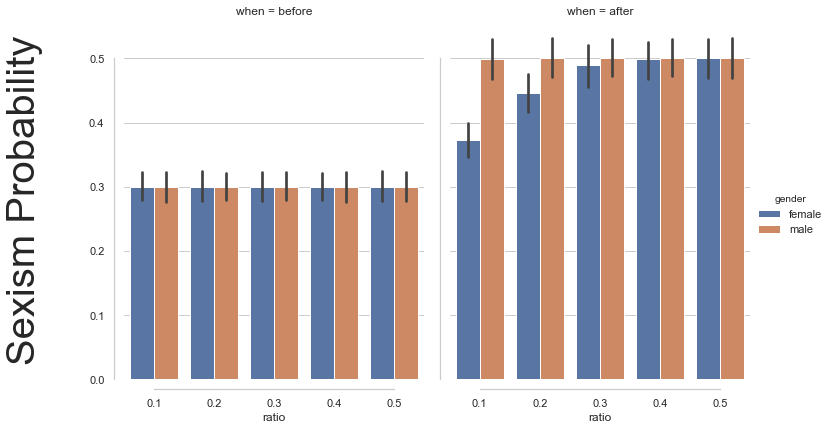

In [46]:
#sns.barplot(x="when", y="sex_prob", hue="gender", data=sexpdf)

plt.figure(figsize=(3,3), dpi= 300)
sns.set(style="whitegrid")

g = sns.catplot(x="ratio", y="sex_prob",
                hue="gender", col="when",
                 data=sexpdf, kind="bar",
                 height=6, aspect=.8)

g.fontsize=40
#g.set_xlabels("Before    After", fontsize=30)
g.set_ylabels("Sexism Probability\n", fontsize=40)

sns.despine(offset=10, trim=True)
plt.savefig(f'sexprob_{prefix}_ratio{gender_ratio}_{n_meetings}_{nsim}sim.png', bbox_inches='tight')
plt.savefig(f'sexprob_{prefix}_ratio{gender_ratio}_{n_meetings}_{nsim}sim.pdf', bbox_inches='tight')

<Figure size 900x900 with 0 Axes>

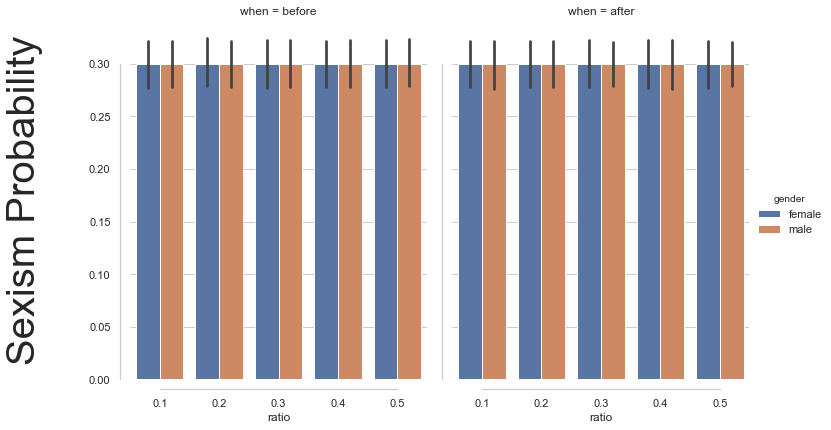

In [24]:
#sns.barplot(x="when", y="sex_prob", hue="gender", data=sexpdf)

plt.figure(figsize=(3,3), dpi= 300)
sns.set(style="whitegrid")

g = sns.catplot(x="ratio", y="sex_prob",
                hue="gender", col="when",
                 data=sexpdf, kind="bar",
                 height=6, aspect=.8)

g.fontsize=40
#g.set_xlabels("Before    After", fontsize=30)
g.set_ylabels("Sexism Probability\n", fontsize=40)

sns.despine(offset=10, trim=True)



<Figure size 3000x2400 with 0 Axes>

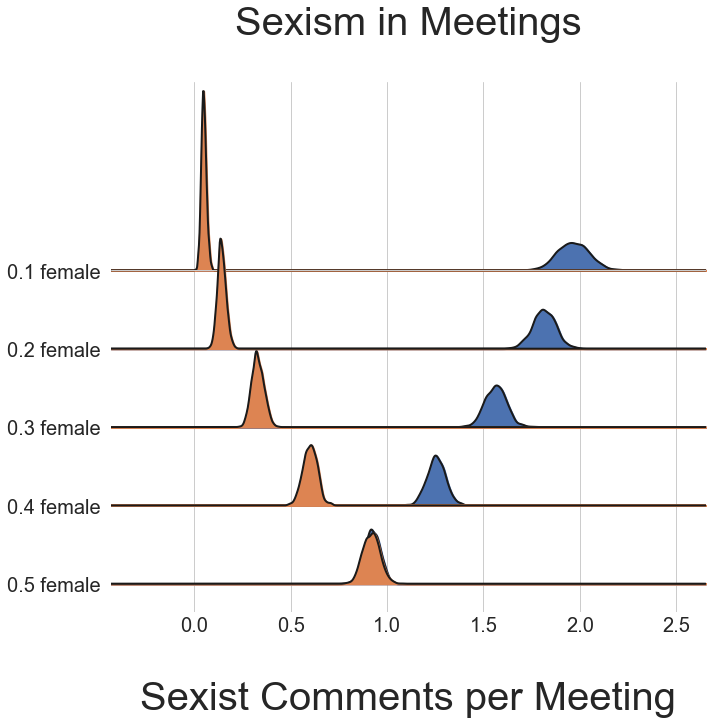

In [6]:
plt.figure(figsize=(10,8), dpi= 300)

fig, ax = joypy.joyplot(joydf, column=['anti_f', 'anti_m'], grid=True,
                        linewidth=2,fade=False,overlap=2.8,
                        by="ratio", ylim='max', figsize=(10,8),kind="kde",
                        xlabelsize=20, ylabelsize=20, 
                        labels=['0.1 female','0.2 female','0.3 female','0.4 female', '0.5 female'] )



plt.title('Sexism in Meetings\n', fontsize=40)
plt.xlabel('\nSexist Comments per Meeting', fontsize=40)
plt.ylabel('Gender Ratio', fontsize=30)
plt.savefig(f'{prefix}_antifm_joyplot_meets{n_meetings}_{nsim}sim.pdf', bbox_inches='tight')
plt.savefig(f'{prefix}_antifm_joyplot_meets{n_meetings}_{nsim}sim.png', bbox_inches='tight')




In [5]:
prefix

'prcost8_inc'

<Figure size 3000x2400 with 0 Axes>

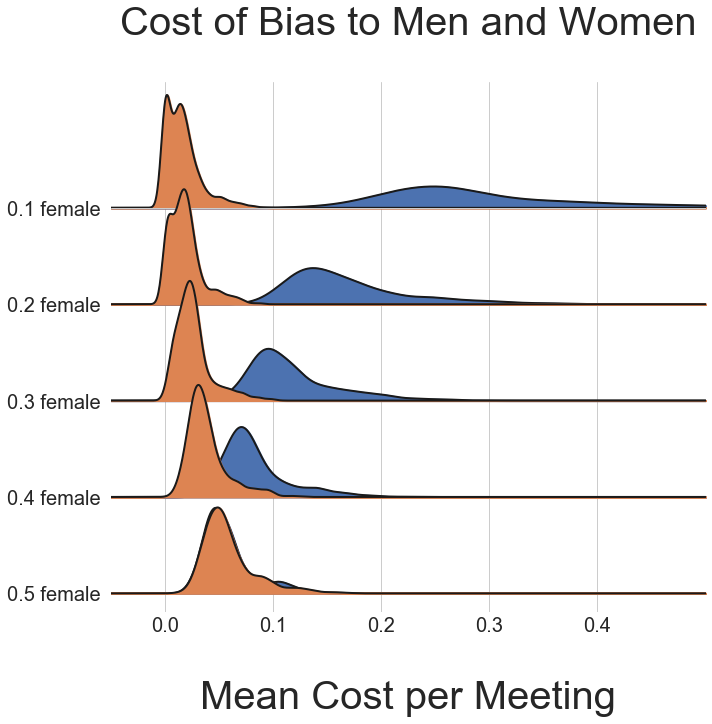

In [18]:
import joypy
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm

plt.figure(figsize=(10,8), dpi= 300)
plt.fontsize=20
fig, ax = joypy.joyplot(costmf_df, column=['costsf', 'costsm'], grid=True,linewidth=2,
                          by="ratio", ylim='max', figsize=(10,8),kind="kde",
                          labels=['0.1 female','0.2 female','0.3 female','0.4 female','0.5 female'], 
                          xlabelsize=20, ylabelsize=20, 
                          x_range=[-.05,.5],overlap=1 )

plt.title('Cost of Bias to Men and Women\n', fontsize=40)
plt.xlabel('\nMean Cost per Meeting', fontsize=40)
plt.ylabel('Gender Ratio', fontsize=30)
plt.savefig(f'{prefix}_joyplot_meets{n_meetings}_{nsim}sim.pdf', bbox_inches='tight')
plt.savefig(f'{prefix}_joyplot_meets{n_meetings}_{nsim}sim.png', bbox_inches='tight')


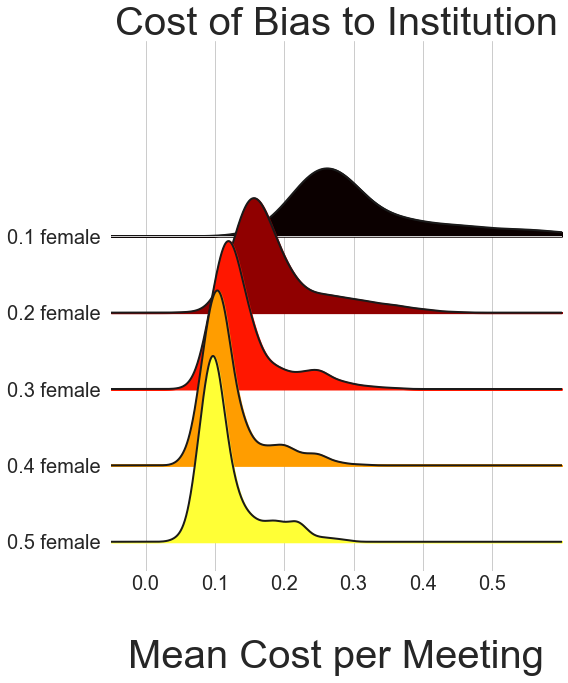

In [9]:

fig, axes = joypy.joyplot(costdf, column=['cost_inst'], by="ratio", overlap=3, grid=True,  
                          x_range=[-.05,.6], figsize=(8,8), linewidth=2,
                         tails=0.5 ,    ylim='max',
                          xlabelsize=20, ylabelsize=20, 
                         labels=['0.1 female','0.2 female','0.3 female','0.4 female','0.5 female'], 
                          colormap=cm.hot )
fig.fontsize=20
#xax=axes.get_xticklabels()
#xax.set_fontsize(20)

plt.title('Cost of Bias to Institution', fontsize=40)
plt.xlabel('\nMean Cost per Meeting', fontsize=40)
plt.ylabel('Gender Ratio', fontsize=30)
plt.savefig(f'prinstcosts_joyplot_meets{n_meetings}_{nsim}sim.pdf', bbox_inches='tight')
plt.savefig(f'prinstcosts_joyplot_meets{n_meetings}_{nsim}sim.png', bbox_inches='tight')


,T,p-val,dof,dof-corr,tail,cohen-d,power,BF10
T-test,0.0,1.0,99998,30767.284038,two-sided,0.0,0.025,0.009


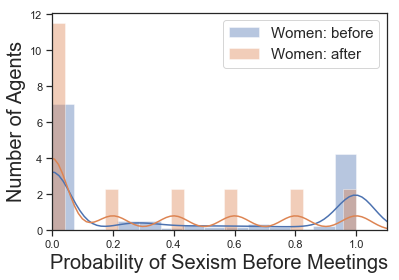

In [276]:
maxx=max(sexm_aft)

sns.distplot(sexf_aft)
sns.distplot(sexf_bef)
#plt.ylim(0, 15 )
plt.xlim(0, 1.1)
plt.xlabel('Probability of Sexism Before Meetings', fontsize=20)
plt.ylabel('Number of Agents', fontsize=20)
plt.legend(['Women: before', 'Women: after'], fontsize=15)

pg.ttest(sexf_bef, sexm_bef)

,T,p-val,dof,dof-corr,tail,cohen-d,power,BF10
T-test,0.0,1.0,99998,30767.284038,two-sided,0.0,0.025,0.009


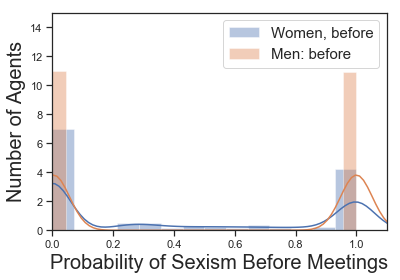

In [266]:
maxx=max(sexm_aft)

sns.distplot(sexf_aft)
sns.distplot(sexm_aft)
plt.ylim(0, 15 )
plt.xlim(0, 1.1)
plt.xlabel('Probability of Sexism Before Meetings', fontsize=20)
plt.ylabel('Number of Agents', fontsize=20)
plt.legend(['Women, before', 'Men: before'], fontsize=15)

pg.ttest(sexf_bef, sexm_bef)

In [225]:
gratios=[.1,.2,.3, .4,.5]
for gratio in gratios:
    pickle_file=f'ratio{gratio}_1000meets_1000nsim.pkl'
    with open(pickle_file, 'rb') as input:
        pickled_args = pickle.load(input)
        pickled_args[0]

In [13]:
# permutation test 
# needs downgrading scipy 1.3 to: !pip install scipy==1.2.1

from mlxtend.evaluate import permutation_test

gratio=.4
pickle_file=f'ratio{gratio}_1000meets_1000nsim.pkl'
with open(pickle_file, 'rb') as input:
        pickled_args = pickle.load(input)        
        anti_f_sexism,anti_m_sexism=pickled_args[0],pickled_args[1]

treatment = anti_f_sexism
control = anti_m_sexism


p_value = permutation_test(treatment, control,
                           method='approximate',
                           num_rounds=10000,
                           seed=0)
print(p_value)

0.0


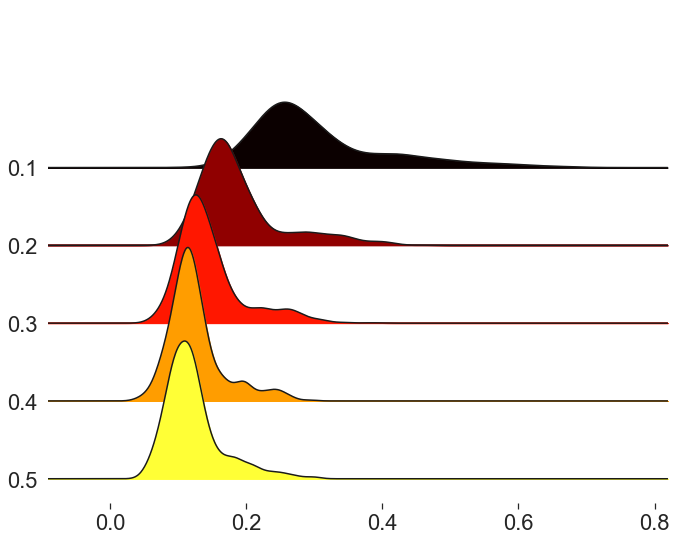

In [215]:

fig, axes = joypy.joyplot(costdf, column=['cost_inst'],colormap=cm.hot, 
                          by="ratio", ylim='max', figsize=(10,8),kind="kde",overlap=1)
   

,T,p-val,dof,tail,cohen-d,power,BF10
T-test,-0.013,0.989797,99998,two-sided,0.0,0.026,0.007


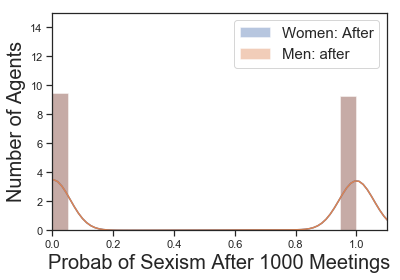

In [229]:
sns.distplot(sexf_aft)
sns.distplot(sexm_aft)


plt.ylim(0, 15)
plt.xlim(0, 1.1)
plt.xlabel(f'Probab of Sexism After {n_meetings} Meetings',fontsize=20)
plt.ylabel('Number of Agents', fontsize=20)
plt.legend(['Women: After', 'Men: after'], fontsize=15)

pg.ttest(sexf_aft, sexm_aft)

## SAVE *probability change* FIGS
plt.savefig(f'probchange_{gender_ratio}_meets{n_meetings}_{nsim}sim.png', bbox_inches='tight')
plt.savefig(f'probchange_{gender_ratio}_meets{n_meetings}_{nsim}sim.pdf', bbox_inches='tight')

pg.ttest(sexf_aft, sexm_aft)



Cost for women: 58.92657
Cost for men:   55.98071200000001
Cost for institution:   114.90728200000001


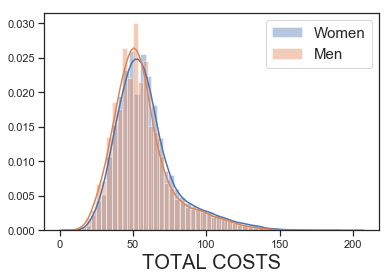

In [12]:
sns.distplot(costsf)
sns.distplot(costsm)
print(f'Cost for women: {np.mean(costsf)}')
print(f'Cost for men:   {np.mean(costsm)}')
print(f'Cost for institution:   {np.mean(costsf)+np.mean(costsm)}')


plt.xlabel('TOTAL COSTS', fontsize=20)

plt.legend(['Women', 'Men'], fontsize=15)

np.mean(costsf)+np.mean(costsm)
pg.ttest(costsf, costsm)

## SAVE *cost* FIGS

plt.savefig(f'costs_{gender_ratio}_meets{n_meetings}_{nsim}sim.png', bbox_inches='tight')
plt.savefig(f'costs_{gender_ratio}_meets{n_meetings}_{nsim}sim.pdf', bbox_inches='tight')

In [1]:
sns.distplot(anti_f_sexism)
sns.distplot(anti_m_sexism)
plt.title(f'Comparing Sexism Against Men & Women \n Gender Ratio={gender_ratio}, {n_meetings} Meetings',fontsize=20)
plt.xlabel(f'Count of Sexism/meeting, {n_meetings} Meetings',fontsize=20)
plt.ylabel('Number of Agents', fontsize=20)
plt.legend(['Anti-female', 'Anti-male'], fontsize=15)
plt.xlim(0, 2)
plt.ylim(0,17)
## SAVE *sexism* FIGS 
plt.savefig(f'ratio{gender_ratio}_meets{n_meetings}_{nsim}sim.png', bbox_inches='tight')
plt.savefig(f'ratio{gender_ratio}_meets{n_meetings}_{nsim}sim.pdf', bbox_inches='tight')

NameError: name 'sns' is not defined

In [ ]:
fig, axes = joypy.joyplot(antidata, by="ratio", overlap=1,grid=True,  #x_range=[0,200],
                         tails=0.1 ,    
                         colormap=cm.hot )


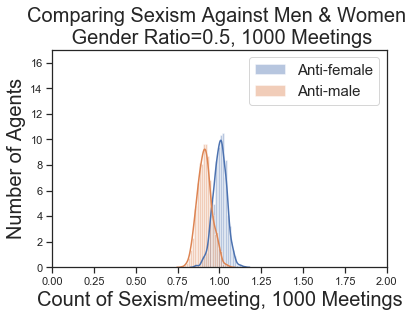

In [13]:
sns.distplot(anti_f_sexism)
sns.distplot(anti_m_sexism)
plt.title(f'Comparing Sexism Against Men & Women \n Gender Ratio={gender_ratio}, {n_meetings} Meetings',fontsize=20)
plt.xlabel(f'Count of Sexism/meeting, {n_meetings} Meetings',fontsize=20)
plt.ylabel('Number of Agents', fontsize=20)
plt.legend(['Anti-female', 'Anti-male'], fontsize=15)
plt.xlim(0, 2)
plt.ylim(0,17)


## SAVE *sexism* FIGS TODO: save ttests
plt.savefig(f'ratio{gender_ratio}_meets{n_meetings}_{nsim}sim.png', bbox_inches='tight')
plt.savefig(f'ratio{gender_ratio}_meets{n_meetings}_{nsim}sim.pdf', bbox_inches='tight')

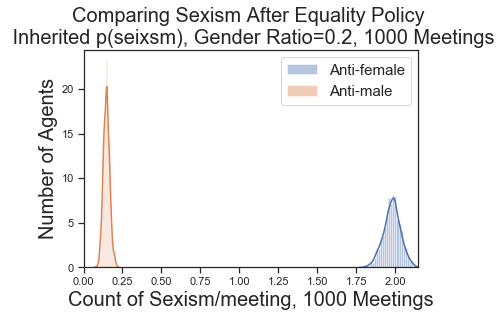

In [18]:
# FOR EQUALITY POLICY ONLY
if pickle_stats:
    sns.distplot(anti_f_sexism)
    sns.distplot(anti_m_sexism)

    plt.title(f'Comparing Sexism After Equality Policy \n Inherited p(seixsm), Gender Ratio={gender_ratio}, {n_meetings} Meetings',fontsize=20)
    plt.xlabel(f'Count of Sexism/meeting, {n_meetings} Meetings',fontsize=20)
    plt.ylabel('Number of Agents', fontsize=20)
    plt.legend(['Anti-female', 'Anti-male'], fontsize=15)
    plt.xlim(0, 2.15)
    ## SAVE *sexism* FIGS TODO: save ttests
    #plt.ylim(0, 31)


    plt.savefig(f'eqpolicy_ratio{gender_ratio}_meets{n_meetings}_{nsim}sim.png', bbox_inches='tight')
    plt.savefig(f'eqpolicy_ratio{gender_ratio}_meets{n_meetings}_{nsim}sim.pdf', bbox_inches='tight')

In [ ]:
sns.distplot(anti_f_sexism)
sns.distplot(anti_m_sexism)
plt.title(f'Comparing Sexism Against Men & Women \n Gender Ratio={gender_ratio}, {n_meetings} Meetings',fontsize=20)
plt.xlabel(f'Count of Sexism/meeting, {n_meetings} Meetings',fontsize=20)
plt.ylabel('Number of Agents', fontsize=20)
plt.legend(['Anti-female', 'Anti-male'], fontsize=15)
plt.xlim(0, 2)
plt.ylim(0,17)
## SAVE *sexism* FIGS TODO: save ttests
plt.savefig(f'ratio{gender_ratio}_meets{n_meetings}_{nsim}sim.png', bbox_inches='tight')
plt.savefig(f'ratio{gender_ratio}_meets{n_meetings}_{nsim}sim.pdf', bbox_inches='tight')

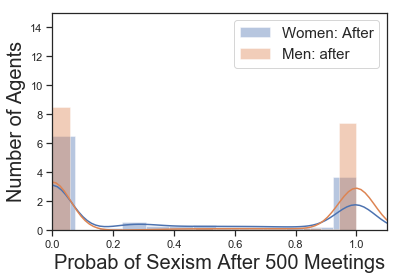

In [31]:
sns.distplot(sexf_aft)
sns.distplot(sexm_aft)

plt.ylim(0, 15)
plt.xlim(0, 1.1)
plt.xlabel(f'Probab of Sexism After {n_meetings} Meetings',fontsize=20)
plt.ylabel('Number of Agents', fontsize=20)
plt.legend(['Women: After', 'Men: after'], fontsize=15)

pg.ttest(sexf_aft, sexm_aft)

## SAVE *probability change* FIGS
plt.savefig(f'probchange_{gender_ratio}_meets{n_meetings}_{nsim}sim.png', bbox_inches='tight')
plt.savefig(f'probchange_{gender_ratio}_meets{n_meetings}_{nsim}sim.pdf', bbox_inches='tight')

<Figure size 1280x800 with 0 Axes>

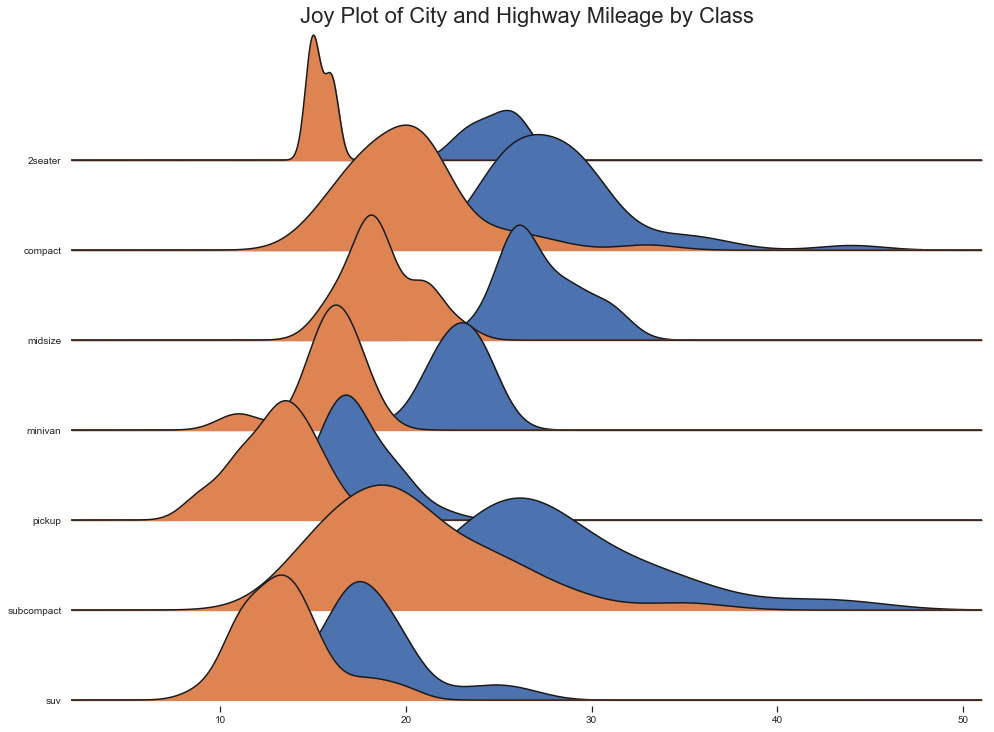

<bound method NDFrame.head of     manufacturer   model  displ  year  cyl       trans drv  cty  hwy fl  \
0           audi      a4    1.8  1999    4    auto(l5)   f   18   29  p   
1           audi      a4    1.8  1999    4  manual(m5)   f   21   29  p   
2           audi      a4    2.0  2008    4  manual(m6)   f   20   31  p   
3           audi      a4    2.0  2008    4    auto(av)   f   21   30  p   
4           audi      a4    2.8  1999    6    auto(l5)   f   16   26  p   
..           ...     ...    ...   ...  ...         ...  ..  ...  ... ..   
229   volkswagen  passat    2.0  2008    4    auto(s6)   f   19   28  p   
230   volkswagen  passat    2.0  2008    4  manual(m6)   f   21   29  p   
231   volkswagen  passat    2.8  1999    6    auto(l5)   f   16   26  p   
232   volkswagen  passat    2.8  1999    6  manual(m5)   f   18   26  p   
233   volkswagen  passat    3.6  2008    6    auto(s6)   f   17   26  p   

       class  
0    compact  
1    compact  
2    compact  
3    comp

In [9]:
mpg = pd.read_csv("https://github.com/selva86/datasets/raw/master/mpg_ggplot2.csv")
# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
fig, axes = joypy.joyplot(mpg, column=['hwy', 'cty'], by="class", ylim='own', figsize=(14,10))

# Decoration
plt.title('Joy Plot of City and Highway Mileage by Class', fontsize=22)
plt.show()


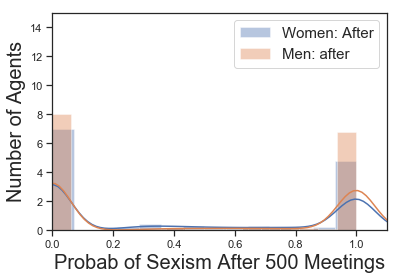

In [38]:
maxy=max(sexm_aft)

sns.distplot(sexf_aft)
sns.distplot(sexm_aft)

plt.ylim(0, 15)
plt.xlim(0, 1.1)
plt.xlabel(f'Probab of Sexism After {n_meetings} Meetings',fontsize=20)
plt.ylabel('Number of Agents', fontsize=20)
plt.legend(['Women: After', 'Men: after'], fontsize=15)

pg.ttest(sexf_aft, sexm_aft)

## SAVE *probability change* FIGS
plt.savefig(f'probchange_{gender_ratio}_meets{n_meetings}_{nsim}sim.png', bbox_inches='tight')
plt.savefig(f'probchange_{gender_ratio}_meets{n_meetings}_{nsim}sim.pdf', bbox_inches='tight')

Cost for women: 114.38464000000002
Cost for men:   7.984592222222221
Cost for institution:   122.36923222222224


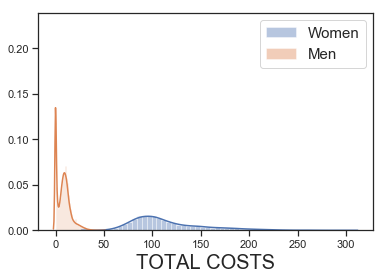

In [67]:
sns.distplot(costsf)
sns.distplot(costsm)
print(f'Cost for women: {np.mean(costsf)}')
print(f'Cost for men:   {np.mean(costsm)}')
print(f'Cost for institution:   {np.mean(costsm)+np.mean(costsf)}')
plt.xlabel('TOTAL COSTS', fontsize=20)
plt.legend(['Women', 'Men'], fontsize=15)

np.mean(costsf)+np.mean(costsm)
pg.ttest(costsf, costsm)

## SAVE *cost* FIGS

plt.savefig(f'costs_{gender_ratio}_meets{n_meetings}_{nsim}sim.png', bbox_inches='tight')
plt.savefig(f'costs_{gender_ratio}_meets{n_meetings}_{nsim}sim.pdf', bbox_inches='tight')

,T,p-val,dof,tail,cohen-d,power,BF10
T-test,-7.471,8.103966e-14,49998,two-sided,0.067,1.0,1.297293e+10


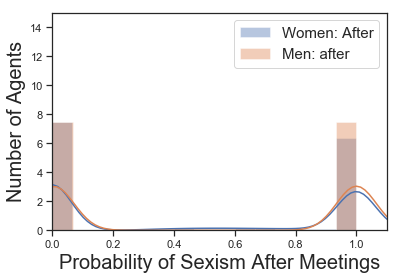

In [3]:
maxy=max(sexm_aft)

sns.distplot(sexf_aft)
sns.distplot(sexm_aft)

plt.ylim(0, 15)
plt.xlim(0, 1.1)
plt.xlabel('Probability of Sexism After Meetings', fontsize=20)
plt.ylabel('Number of Agents', fontsize=20)
plt.legend(['Women: After', 'Men: after'], fontsize=15)

pg.ttest(sexf_aft, sexm_aft)

In [8]:
use_the_past = 1
if use_the_past:
    pickle_file='env_sex_prob_args.pkl'
    with open(pickle_file, 'rb') as input:
        pickled_args = pickle.load(input)
pickled_args

([0.0,
  0.0,
  0.0,
  0.0,
  0.00017715610000000007,
  0.9920796288104013,
  1.0,
  1.0,
  1.0,
  1.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0004,
  0.3171369691851001,
  0.6883991150378722,
  0.9940524636671999,
  1.0,
  1.0])

In [8]:
www=2
if www>0:
    a=np.asarray(sexm_aft)
    b=np.asarray(sexf_aft)
    a.sort()
    b.sort()
    # turning probabilities into 10 percentiles
    num=10
    chunk=int(len(a)/10) 
    chunkf=int(len(b)/10)

    new_sexpm=[np.mean(a[i*(chunk+1):i*(chunk+1)+chunk]) for i in range(num)]
    new_sexpf=[np.mean(b[i*(chunkf+1):i*(chunkf+1)+chunkf]) for i in range(num)]

    print(new_sexpm, new_sexpf)

    # save them and use them in the next round
    env_sex_prob_args=(new_sexpm, new_sexpf)
    import pickle
    with open('env_sex_prob_args.pkl', 'wb') as output:
        pickle.dump(env_sex_prob_args, output, pickle.HIGHEST_PROTOCOL)


[0.0007269100481111112, 0.0011312639952610333, 0.0016610832940960208, 0.002496202296225077, 0.005436525464722305, 0.9039283038717141, 1.0, 1.0, 1.0, 1.0] [0.0, 0.0, 0.00020400000000000008, 0.0005000000000000002, 0.0013636343405, 0.23659036754000004, 0.4990031295382001, 0.7974196824415999, 0.9957760000000001, 1.0]


,T,p-val,dof,tail,cohen-d,power,BF10
T-test,43.5,1.134466e-232,998,two-sided,2.751,1.0,2.073291e+228


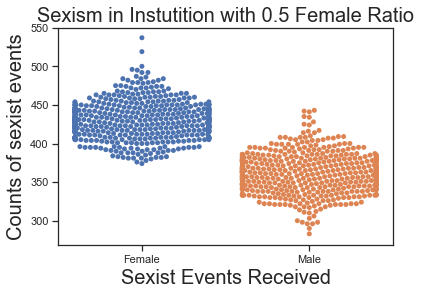

In [14]:
sim_dataframe=pd.DataFrame({'Female':anti_f_sexism, 
                            'Male':anti_m_sexism})
    
sns.swarmplot(data=sim_dataframe)
#sns.violinplot(X="Female", Y="Male",data=sim_dataframe, inner="point")

plt.xlabel('Sexist Events Received', fontsize=20)
plt.ylabel('Counts of sexist events', fontsize=20)
plt.title(f'Sexism in Instutition with {gender_ratio} Female Ratio', fontsize=20)
pg.ttest(anti_f_sexism, anti_m_sexism)



,T,p-val,dof,tail,cohen-d,power,BF10
T-test,108.612,0.0,998,two-sided,6.869,1.0,inf


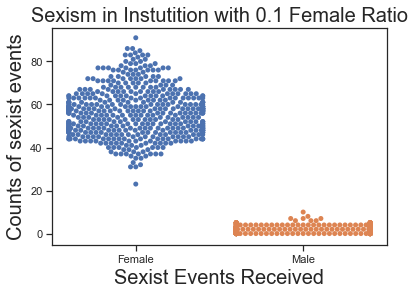

In [7]:
sim_dataframe=pd.DataFrame({'Female':anti_f_sexism, 
                            'Male':anti_m_sexism})
    
sns.swarmplot(data=sim_dataframe)
#sns.violinplot(X="Female", Y="Male",data=sim_dataframe, inner="point")

plt.xlabel('Sexist Events Received', fontsize=20)
plt.ylabel('Counts of sexist events', fontsize=20)
plt.title(f'Sexism in Instutition with {gender_ratio} Female Ratio', fontsize=20)
pg.ttest(anti_f_sexism, anti_m_sexism)


,T,p-val,dof,tail,cohen-d,power,BF10
T-test,162.51,0.0,1998,two-sided,7.268,1.0,inf


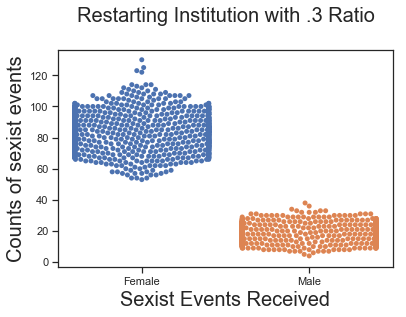

In [20]:
sim_dataframe=pd.DataFrame({'Female':anti_f_sexism, 
                            'Male':anti_m_sexism})
    
sns.swarmplot(data=sim_dataframe)
#sns.violinplot(X="Female", Y="Male",data=sim_dataframe, inner="point")

plt.xlabel('Sexist Events Received', fontsize=20)
plt.ylabel('Counts of sexist events', fontsize=20)
plt.title('Restarting Institution with .3 Ratio\n ', fontsize=20)
pg.ttest(anti_f_sexism, anti_m_sexism)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pingouin/bayesian.py:114: RuntimeWarning: divide by zero encountered in double_scalars
  return np.round(1 / bf01, 3)


,T,p-val,dof,tail,cohen-d,power,BF10
T-test,89.164,0.0,1998,two-sided,3.988,1.0,inf


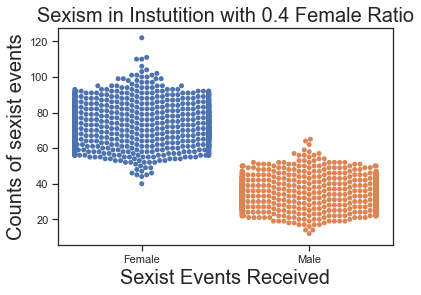

In [22]:
sim_dataframe=pd.DataFrame({'Female':anti_f_sexism, 
                            'Male':anti_m_sexism})
    
sns.swarmplot(data=sim_dataframe)
#sns.violinplot(X="Female", Y="Male",data=sim_dataframe, inner="point")

plt.xlabel('Sexist Events Received', fontsize=20)
plt.ylabel('Counts of sexist events', fontsize=20)
plt.title(f'Sexism in Instutition with {gender_ratio} Female Ratio', fontsize=20)
pg.ttest(anti_f_sexism, anti_m_sexism)



,T,p-val,dof,tail,cohen-d,power,BF10
T-test,32.603,2.525736e-187,1998,two-sided,1.458,1.0,1.427441e+183


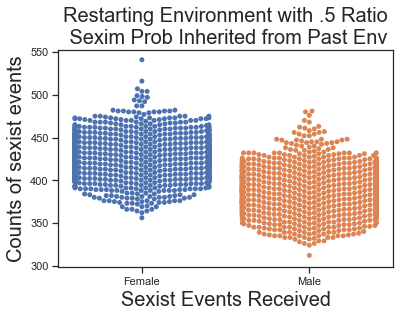

In [3]:
sim_dataframe=pd.DataFrame({'Female':anti_f_sexism, 
                            'Male':anti_m_sexism})
    
sns.swarmplot(data=sim_dataframe)
#sns.violinplot(X="Female", Y="Male",data=sim_dataframe, inner="point")

plt.xlabel('Sexist Events Received', fontsize=20)
plt.ylabel('Counts of sexist events', fontsize=20)
plt.title('Restarting Environment with .5 Ratio\n Sexim Prob Inherited from Past Env', fontsize=20)
pg.ttest(anti_f_sexism, anti_m_sexism)



,T,p-val,dof,tail,cohen-d,power,BF10
T-test,-81.313,0.0,1998,two-sided,3.636,1.0,inf


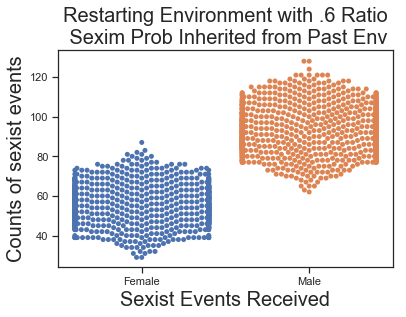

In [14]:
sim_dataframe=pd.DataFrame({'Female':anti_f_sexism, 
                            'Male':anti_m_sexism})
    
sns.swarmplot(data=sim_dataframe)
#sns.violinplot(X="Female", Y="Male",data=sim_dataframe, inner="point")

plt.xlabel('Sexist Comments Received', fontsize=20)
plt.ylabel('Counts of Sexist Comments', fontsize=20)
plt.title('Restarting Environment with .6 Ratio\n Sexim Prob Inherited from Past Env', fontsize=20)
pg.ttest(anti_f_sexism, anti_m_sexism)


,T,p-val,dof,tail,cohen-d,power,BF10
T-test,-95.64,0.0,1998,two-sided,4.277,1.0,inf


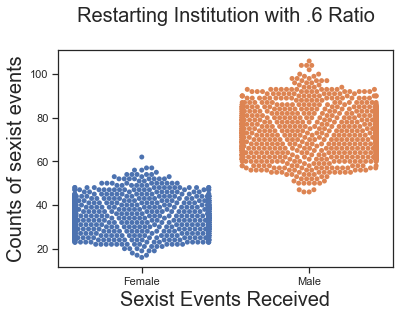

In [16]:
sim_dataframe=pd.DataFrame({'Female':anti_f_sexism, 
                            'Male':anti_m_sexism})
    
sns.swarmplot(data=sim_dataframe)
#sns.violinplot(X="Female", Y="Male",data=sim_dataframe, inner="point")

plt.xlabel('Sexist Events Received', fontsize=20)
plt.ylabel('Counts of sexist events', fontsize=20)
plt.title('Restarting Institution with .6 Ratio\n ', fontsize=20)
pg.ttest(anti_f_sexism, anti_m_sexism)

In [24]:
a=env.agent_list
len(a)
allsp, allg, costs, pobj, pally=[],[],[], [], []
for i in range(len(a)):
    allsp.append(a[i].sexism)
    allg.append(a[i].gender)
    costs.append(a[i].total_cost)
    pobj.append(a[i].objp)
    pally.append(a[i].allyp)
agent_df=pd.DataFrame({'gender':allg, 
                        'p_sexism':allsp,'p_object':pobj,'p_ally':pally,
                        'costs':costs})

0.35142555
0.4682440259164064


,T,p-val,dof,dof-corr,tail,cohen-d,power,BF10
T-test,-1.069,0.29293,98,32.39473,two-sided,0.248,0.164,0.414


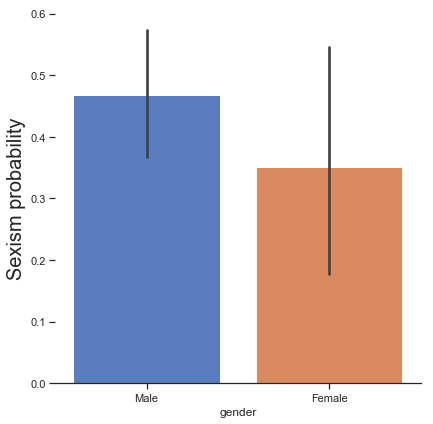

In [25]:
fems=agent_df.loc[agent_df.gender=='Female', ['p_sexism']]
print(np.mean(fems.p_sexism))

men=agent_df.loc[agent_df.gender=='Male', ['p_sexism']]
print(np.mean(men.p_sexism))


g = sns.catplot(x="gender", y="p_sexism", data=agent_df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Sexism probability", fontsize=20)

import pingouin as pg

pg.ttest(fems, men)

In [32]:
# save dataframe to csv
file_name = 'conv2k_nsim2k_f20_m80.csv'
sim_dataframe.to_csv(file_name, sep='\t', encoding='utf-8')
sim_dataframe.info(memory_usage='deep')
#sim_dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
Antifemale    2000 non-null float64
Antimale      2000 non-null float64
dtypes: float64(2)
memory usage: 31.3 KB


In [8]:
# save object env using pickle
# so we can use it again later by injecting women into the environment
import pickle
with open('env_1kconv_1k_20_80.pkl', 'wb') as output:
    pickle.dump(env, output, pickle.HIGHEST_PROTOCOL)
    
with open('env_1kconv_1k_20_80.pkl', 'rb') as input:
    pickled_env = pickle.load(input)



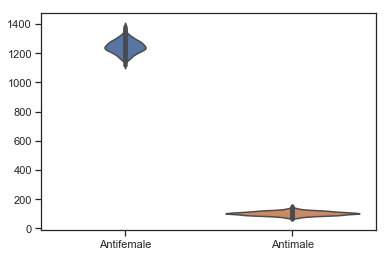

In [45]:
sns.violinplot(X="Antifemale", Y="Antimale",data=sim_dataframe, inner="point")



In [22]:
percentage_sexism = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
prob_sexism = [0.5, 0.1, 0.1, 0.1, 0.1, 0.1]

sexism=random.sample(percentage_sexism, 1)
sexism

[0.6]

In [7]:
# little side to acecss agents 
a1=env.agent_list[10]
a1.sexism
i=8
what=i in c1.convo_agents
what
env.agent_list[20].id
env.agent_list[34].cost_received


0

In [108]:
# testing how long different loops take to optimize speed
#%%timeit
chunk=int(len(a)/10) 
newmale_sexp=[np.mean(a[i*(chunk+1):i*(chunk+1)+chunk]) for i in range(num)]

#%%timeit
b2=[]
for i in range(num):
    start= i*8000+i
    b2.append(np.mean(a[start:start+8000]))
print(b2)

218 µs ± 35.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [28]:
print('Final results after %s simualtions of 500 conversations:' % nsim)
print('anti f sexism: %s ' % env.anti_f_sexism   )
print('anti m sexism: %s ' % env.anti_m_sexism   )
print('total sexism: %s ' % env.total_sexism   )
print('single gender conversations: %s' % env.conv_no_sexism)


Final results after 1000 simualtions of 500 conversations:
anti f sexism: 48 
anti m sexism: 1 
total sexism: 0 
single gender conversations: 190
